In [3]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt




In [4]:

def sqrtm_numpy_batch(batch_A):
    # Eigenvalue decomposition for symmetric matrices
    eigvals, eigvecs = np.linalg.eigh(batch_A)

    # Taking square root of the eigenvalues
    sqrt_eigvals = np.sqrt(eigvals)

    # Reconstruct each matrix in the batch: sqrt(A) = V * sqrt(D) * V^T
    sqrt_A = np.einsum('...ij,...j,...kj->...ik', eigvecs, sqrt_eigvals, eigvecs)

    return sqrt_A

def RSCM(x, alpha):
    N, n, d = x.shape
    SCM = x.swapaxes(2,1) @ x / n
    return SCM + alpha * np.eye(d)


def KA(x, alpha, C_prior):
    N, n, d = x.shape
    SCM = x.swapaxes(2,1) @ x / n
    return SCM * (1-alpha) + alpha * C_prior

def RSCM2(x, alpha):

    N, n, d = x.shape
    SCM = x.swapaxes(2,1) @ x / n
    mu = np.trace(SCM, axis1=1, axis2=2) / d
    return   (1 - alpha) * SCM + alpha * mu.reshape(-1,1,1) * np.eye(d)


def Frobenious(C1, C2):
    return np.linalg.norm(C1 - C2, ord='fro', axis=(1,2))

def Spectral(C1, C2):
    return np.linalg.norm(C1 - C2, ord=2, axis=(1,2))


def kl(sigma_true, sigma_est):
    d = sigma_true.shape[-1]
    inv_sigma_est = np.linalg.inv(sigma_est)
    trace_term = np.trace(inv_sigma_est @ sigma_true, axis1=1, axis2=2)
    log_det_term = (np.linalg.slogdet(sigma_est)[1] - np.linalg.slogdet(sigma_true)[1])
    return (trace_term - d + log_det_term)

def sym_kl(sigma_true, sigma_est):
  return (kl(sigma_true, sigma_est) + kl(sigma_est, sigma_true)) / 2

def nsnr_single(sigma_true, sigma_est):
    sqrtinvest = sqrtm(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.T
    eigQ = np.linalg.eigh(Q)[0]
    qmax = np.max(eigQ)
    qmin = np.min(eigQ)
    cond = qmax/qmin + 1e-6
    return np.log((cond+1)**2/4/cond)


def nsnr(sigma_true, sigma_est):
    sqrtinvest = sqrtm_numpy_batch(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.swapaxes(2,1)
    eigQ = np.linalg.eigh(Q)[0]
    qmax = np.max(eigQ,1)
    qmin = np.min(eigQ,1)
    cond = qmax/qmin + 1e-6
    return np.log((cond+1)**2/4/cond)



def nsnr_old(sigma_true, sigma_est):
    return np.array([nsnr_single(sigma_true, sigma_est[i]) for i in range(sigma_est.shape[0])])


def wishart_samples(df, scale_matrix, n_samples):
    """
    Generate multiple samples from a Wishart distribution.

    Parameters:
    df: degrees of freedom (nu)
    scale_matrix: scale matrix (covariance matrix)
    n_samples: number of Wishart samples to generate

    Returns:
    An array of Wishart-distributed matrices.
    """
    n = scale_matrix.shape[0]  # Dimensionality
    chol_scale = np.linalg.cholesky(scale_matrix)

    # Array to store Wishart samples
    samples = np.zeros((n_samples, n, n))

    for i in range(n_samples):
        wishart_matrix = np.zeros((n, n))

        # Sample df times for each Wishart sample
        for j in range(df):
            z = np.random.normal(size=(n,))
            x = chol_scale @ z
            wishart_matrix += np.outer(x, x)

        samples[i] = wishart_matrix

    return samples

In [8]:
np.random.seed(1)
d = 10
n = 50
N = 1000
A = np.random.randn(d , 3 )
C0 = A @ A.swapaxes(1,0) / 5

A = np.random.randn(N, d , d )
C_train = 1 * A @ A.swapaxes(2,1) / (d ) + C0

C_half = sqrtm_numpy_batch(C_train)
x_train = np.random.randn(N, n, d) @  C_half

C_prior = x_train.reshape(-1,d ).T @ x_train.reshape(-1,d ) / (n * N)

## Bayesian test
# A = np.random.randn(N, d , d )
# C = A @ A.swapaxes(2,1) / (d ) + C0
# C_half = sqrtm_numpy_batch(C)
# x = np.random.randn(N, n, d) @  C_half

## classical test

A = np.random.randn(d , d )
C = 1 * A @ A.swapaxes(1,0) / (d ) + C0


C_half = sqrtm_numpy_batch(C)
x = np.random.randn(N, n, d) @  C_half


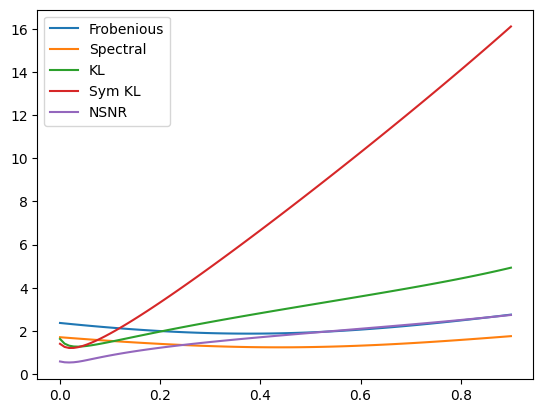

In [11]:
alpha = np.linspace(0, 0.9, 100)
frob_err = []
spectral_err = []
kl_err = []
sym_kl_err = []
nsnr_err = []
nsnr_acc = []
for a in alpha:
    SCM = KA(x, a, C_prior)
    frob_err.append(np.mean(Frobenious(C, SCM)))
    spectral_err.append(np.mean(Spectral(C, SCM)))
    kl_err.append(np.mean(kl(C, SCM)))
    sym_kl_err.append(np.mean(sym_kl(C, SCM)))
    nsnr_err.append(np.mean(nsnr(C, SCM)))
    nsnr_acc.append(np.mean(np.exp(-0.5 * nsnr(C, SCM))))
plt.plot(alpha, frob_err, label='Frobenious')
plt.plot(alpha, spectral_err, label='Spectral')
plt.plot(alpha, kl_err, label='KL')
plt.plot(alpha, sym_kl_err, label='Sym KL')
plt.plot(alpha, nsnr_err, label='NSNR')
plt.legend()
plt.show()



In [12]:
ind_frob = np.argmin(frob_err)
ind_spectral = np.argmin(spectral_err)
ind_kl = np.argmin(kl_err)
ind_sym_kl = np.argmin(sym_kl_err)
ind_nsnr = np.argmin(nsnr_err)
print('            ','frob', 'spectral', 'kl', 'sym_kl', 'nsnr')
print('best shinkage:',round(alpha[ind_frob],2), round(alpha[ind_spectral],2), round(alpha[ind_kl],2), round(alpha[ind_sym_kl],2), round(alpha[ind_nsnr],2))
print('nsnr distance:', round(nsnr_acc[ind_frob],2), round(nsnr_acc[ind_spectral],2),round(nsnr_acc[ind_kl],2), round(nsnr_acc[ind_sym_kl],2), round(nsnr_acc[ind_nsnr],2))

             frob spectral kl sym_kl nsnr
best shinkage: 0.38 0.44 0.04 0.02 0.02
nsnr distance: 0.43 0.41 0.75 0.76 0.76
